<a href="https://colab.research.google.com/github/bbcndoro/bigData/blob/kris/TugasPysparkDataSuara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Instal PySpark (biasanya cukup ini di Colab)
!pip install pyspark --quiet

from pyspark.sql import SparkSession

# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("AudioFeaturesAnalysis") \
    .getOrCreate()

spark

In [50]:
import os
import zipfile

KAGGLE_USERNAME = "masyadi"
KAGGLE_KEY      = "KGAT_23c2e9a32f90ad34beaffaf8eb5c25f1"

KAGGLE_DATASET  = "dipayanbiswas/parkinsons-disease-speech-signal-features"
LOCAL_DATA_DIR  = "./kaggle_data"
DATA_FILE_NAME  = "pd_speech_features.csv"

os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"]      = KAGGLE_KEY


In [51]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

api = KaggleApi()
api.authenticate()

print("Downloading dataset Parkinson dari Kaggle...")
api.dataset_download_files(KAGGLE_DATASET, path=LOCAL_DATA_DIR, unzip=False)

# Cari file zip
zip_files = [f for f in os.listdir(LOCAL_DATA_DIR) if f.endswith(".zip")]
zip_path = os.path.join(LOCAL_DATA_DIR, zip_files[0])

print("Extracting zip file...")
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(LOCAL_DATA_DIR)

print("Dataset siap digunakan.")


Dataset URL: https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features
Extracting zip file...
Dataset siap digunakan.


In [52]:
# LOAD CSV KE SPARK
from pyspark.sql.types import NumericType

csv_path = os.path.join(LOCAL_DATA_DIR, DATA_FILE_NAME)

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(csv_path)

df.printSchema()
print("Jumlah baris:", df.count())
df.show(5, truncate=False)


root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- PPE: double (nullable = true)
 |-- DFA: double (nullable = true)
 |-- RPDE: double (nullable = true)
 |-- numPulses: integer (nullable = true)
 |-- numPeriodsPulses: integer (nullable = true)
 |-- meanPeriodPulses: double (nullable = true)
 |-- stdDevPeriodPulses: double (nullable = true)
 |-- locPctJitter: double (nullable = true)
 |-- locAbsJitter: double (nullable = true)
 |-- rapJitter: double (nullable = true)
 |-- ppq5Jitter: double (nullable = true)
 |-- ddpJitter: double (nullable = true)
 |-- locShimmer: double (nullable = true)
 |-- locDbShimmer: double (nullable = true)
 |-- apq3Shimmer: double (nullable = true)
 |-- apq5Shimmer: double (nullable = true)
 |-- apq11Shimmer: double (nullable = true)
 |-- ddaShimmer: double (nullable = true)
 |-- meanAutoCorrHarmonicity: double (nullable = true)
 |-- meanNoiseToHarmHarmonicity: double (nullable = true)
 |-- meanHarmToNoiseHarmonicity: double (nu

In [53]:
# Ambil semua kolom numerik dari DataFrame Spark
numeric_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Jumlah fitur numerik:", len(numeric_cols))
print("10 fitur pertama:", numeric_cols[:10])

df_features = df.select(*numeric_cols)
df_features.describe().show()


Jumlah fitur numerik: 755
10 fitur pertama: ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter']
+-------+-----------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-----------------------+--------------------------+--------------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+-------------------+-------------

In [54]:
from pyspark.sql.types import NumericType

# Ambil semua kolom numerik dari DataFrame Spark
numeric_cols = [
    field.name for field in df.schema.fields
    if isinstance(field.dataType, NumericType)
]

print("Contoh kolom numerik:",len(numeric_cols))
print("Contoh kolom numerik:", numeric_cols[:10])
print("Contoh kolom numerik:", df.count())

import matplotlib.pyplot as plt

#pastikan matplotlib aktif di notebook
%matplotlib inline

# Pilih hanya kolom numerik
df_features = df.select(*numeric_cols)

# Statistik deskriptif dasar
df_features.describe().show()



# Ambil maks 500 baris untuk visualisasi
pdf_feat = df_features.limit(500).toPandas()

print("Ukuran pdf_feat", pdf_feat.shape)
print(pdf_feat.head())


Contoh kolom numerik: 755
Contoh kolom numerik: ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter']
Contoh kolom numerik: 756
+-------+-----------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-----------------------+--------------------------+--------------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+---

Scatter: id vs gender


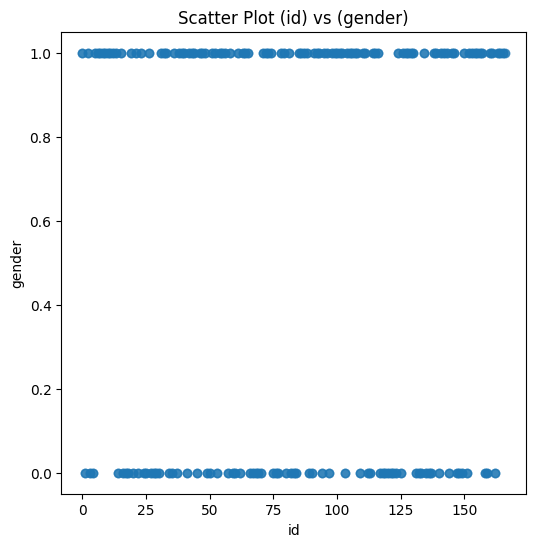

In [55]:
# === Scatter Plot ===
if len(numeric_cols) >= 2 and len(pdf_feat) > 0:
    x_col = numeric_cols[0]
    y_col = numeric_cols[1]
    print("Scatter:", x_col, "vs", y_col)

    plt.figure(figsize=(6, 6))
    plt.scatter(pdf_feat[x_col], pdf_feat[y_col], alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Scatter Plot ({x_col}) vs ({y_col})")
    plt.show()
else:
    print("Tidak cukup data/fitur untuk scatter plot.")

Kolom untuk boxplot: ['id', 'gender', 'PPE', 'DFA', 'RPDE']


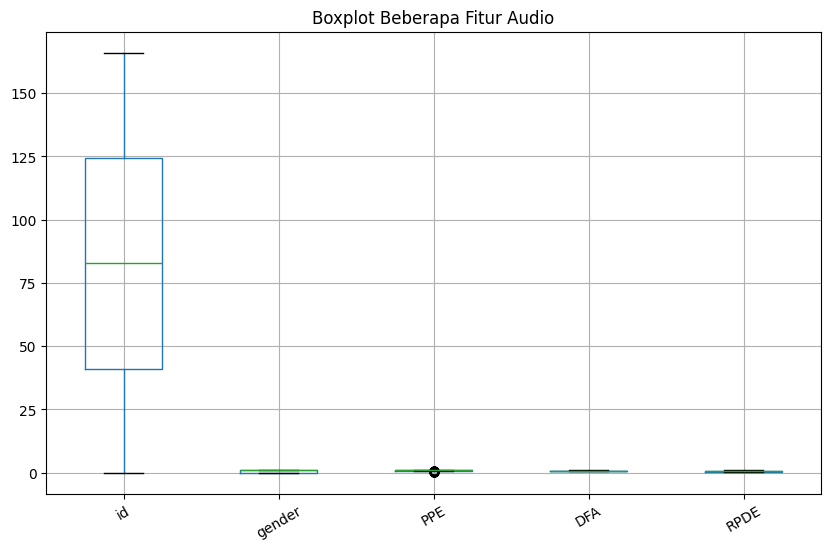

In [56]:
# === Boxplot (5 fitur pertama) ===
box_cols = numeric_cols[:5]
print("Kolom untuk boxplot:", box_cols)

if box_cols and len(pdf_feat) > 0:
    plt.figure(figsize=(10, 6))
    pdf_feat[box_cols].boxplot()
    plt.title("Boxplot Beberapa Fitur Audio")
    plt.xticks(rotation=30)
    plt.show()
else:
    print("Tidak ada data atau kolom numerik untuk boxplot.")

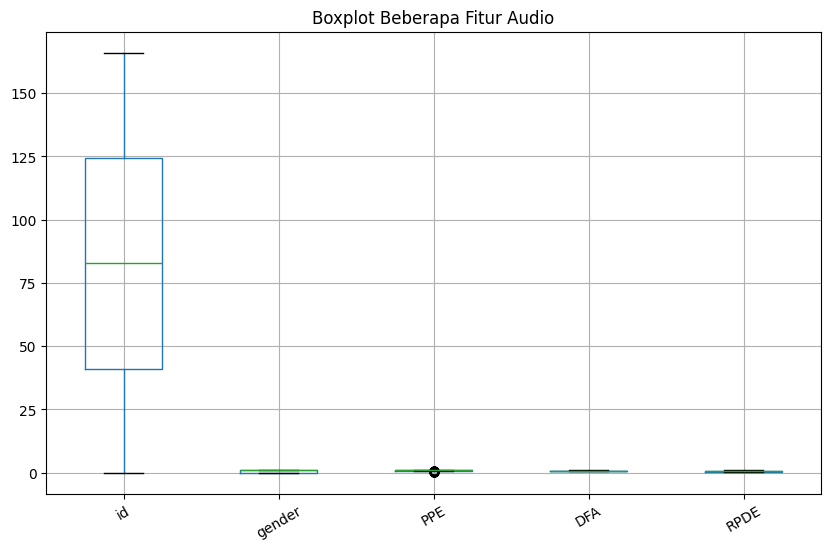

In [57]:
# (Kode boxplot kedua pada slide — sebenarnya sama)
box_cols = numeric_cols[:5]
if box_cols and len(pdf_feat) > 0:
    plt.figure(figsize=(10, 6))
    pdf_feat[box_cols].boxplot()
    plt.title("Boxplot Beberapa Fitur Audio")
    plt.xticks(rotation=30)
    plt.show()
else:
    print("Tidak ada data atau kolom numerik untuk boxplot.")

Fitur untuk histogram: id


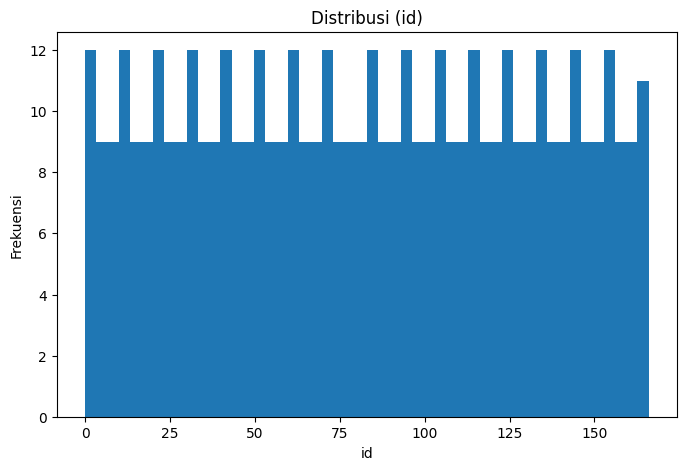

In [58]:
# === Histogram (fitur pertama) ===
if numeric_cols and len(pdf_feat) > 0:
    feature_for_hist = numeric_cols[0]
    print("Fitur untuk histogram:", feature_for_hist)

    plt.figure(figsize=(8, 5))
    plt.hist(pdf_feat[feature_for_hist].dropna(), bins=50)
    plt.xlabel(feature_for_hist)
    plt.ylabel("Frekuensi")
    plt.title(f"Distribusi ({feature_for_hist})")
    plt.show()

else:
    print("Tidak ada data/fitur untuk histogram.")